# Finding minimal viable communities

Community genome-scale metabolic models (cGEMs) are meta-models which integrate individual genome-scale metabolic models (GEMs) of species in a community. To this end, individual models shared the same external environment (with its compounds), providing a way to couple the individual model flux spaces. The following toy community model depicts three interacting species $A-C$ (i.e., GEMs) and three shared, external metabolites, $e_1-e_3$. Individual GEMs interact through boundaty reactions that export/import external metabolites into/from the shared environment. The community model is thus composed of the internal reactions of each individual model, the boundary reactions connecting the external metabolites to the internal reactions of each model, and the external compounds present in the environment. Note that an additional exchange reaction is added for each external compound, to account for other processes that may affect the concentration of external compounds, e.g., diffusion, degradation, etc.

<div style="text-align:center; width:100%"><img src="images/toy_community_model.png" style="max-width:30%;"></div>

## Using the [Micom](https://micom-dev.github.io/micom/index.html) package

__NOTES__:

For what I understand, Micom requires a GEM database following a specific format given by QIIME2 (see https://github.com/micom-dev/q2-micom). There are some available nextflow workflows to do this.

Alright, it seems like there is no need to build a q2-micom database. One can also follow the approach described in [this issue](https://github.com/micom-dev/micom/issues/31). Basically, including model files in a pandas df:

```python
> df.head()
    sample_id   id  abundance                          file
0  sample1  taxa1   0.364398  /data/model.taxa1.xml.gz
1  sample1  taxa2   0.029670  /data/model.taxa2.xml.gz
2  sample1  taxa3   0.016877  /data/model.taxa3.xml.gz
...
```

and then running:

```python
from micom.workflows import build
manifest = build( taxonomy = df , model_db = None , out_folder = '/data/out', cutoff = 1e-2 , threads = 8 , solver = 'cplex')
```

In [1]:
import pandas as pd

taxo_df = pd.read_csv("../data/genomes/micom_database.csv", sep=",", index_col=None)
taxo_df

,sample_id,id,abundance,file
0,TARA_ARC_108,Alteromonas_sp,0.364398,/home/robaina/Documents/NewAtlantis/phycospher...
1,TARA_ARC_108,Marinobacter_sp,0.029670,/home/robaina/Documents/NewAtlantis/phycospher...
2,TARA_ARC_108,Polaribacter_sp,0.016877,/home/robaina/Documents/NewAtlantis/phycospher...
3,TARA_ARC_108,Sulfitobacter_sp,0.100000,/home/robaina/Documents/NewAtlantis/phycospher...


In [8]:
# Create taxonomy - model database
from micom.workflows import build

manifest = build(taxonomy=taxo_df, model_db=None, out_folder="../results/micom", cutoff=1e-2, threads=8 , solver="gurobi")
manifest

[13:02:33] WARNING  Found existing models for 1 samples. Will skip those. Delete the output folder if   ]8;id=467858;file:///home/robaina/miniconda3/envs/phycogem/lib/python3.11/site-packages/micom/workflows/build.py\build.py]8;;\:]8;id=916719;file:///home/robaina/miniconda3/envs/phycogem/lib/python3.11/site-packages/micom/workflows/build.py#95\95]8;;\
                    you would like me to rebuild them.                                                             

Output()

Read LP format model from file /tmp/tmpd1cpuca6.lp
Reading time = 0.06 seconds
: 7675 rows, 22659 columns, 97575 nonzeros


,sample_id,file
0,TARA_ARC_108,TARA_ARC_108.pickle


In [2]:
from micom import load_pickle

cgem = load_pickle("../results/micom/TARA_ARC_108.pickle")
cgem

Set parameter Username

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2023-11-05
Read LP format model from file /tmp/tmpluoauq3s.lp
Reading time = 0.06 seconds
: 7675 rows, 22659 columns, 97575 nonzeros


Name,TARA_ARC_108
Memory address,7f1931678a90
Number of metabolites,7670
Number of reactions,11329
Number of genes,3097
Number of groups,0
Objective expression,1.0*community_objective
Compartments,"p__Alteromonas_sp, c__Alteromonas_sp, e__Alteromonas_sp, m, e__Marinobacter_sp, p__Marinobacter_sp, c__Marinobacter_sp, p__Polaribacter_sp, c__Polaribacter_sp, e__Polaribacter_sp, e__Sulfitobacter_sp, p__Sulfitobacter_sp, c__Sulfitobacter_sp"


In [3]:
cgem.optimize()

,abundance,growth_rate,reactions,metabolites
compartments,,,,
Alteromonas_sp,0.577543,2.208998,2990,2013
Marinobacter_sp,0.047025,10.479906,3231,2085
Polaribacter_sp,0.026749,3.390215,1909,1300
Sulfitobacter_sp,0.348683,0.000000,2752,1825
medium,NaN,NaN,447,447


In [14]:
medium_dict = {k:v for k,v in cgem.medium.items() if k != "EX_glc__D_m"}
medium_dict["EX_tol_m"] = 10.0

In [18]:
import pandas as pd

medium_df = pd.DataFrame.from_dict(medium_dict, orient='index', columns=['flux'])
medium_df.index.name = 'reaction'
medium_df.reset_index(inplace=True)
medium_df.head()


,reaction,flux
0,EX_h_m,10.0
1,EX_btn_m,10.0
2,EX_ca2_m,10.0
3,EX_cl_m,10.0
4,EX_co2_m,10.0


In [17]:
cgem.medium = medium_dict
cgem.optimize()

,abundance,growth_rate,reactions,metabolites
compartments,,,,
Alteromonas_sp,0.577543,0.000000,2990,2013
Marinobacter_sp,0.047025,7.575229,3231,2085
Polaribacter_sp,0.026749,3.408142,1909,1300
Sulfitobacter_sp,0.348683,0.000000,2752,1825
medium,NaN,NaN,447,447


In [19]:
from micom.workflows import fix_medium

medium = fix_medium(manifest, model_folder="../results/micom/", medium=medium_df,
                    community_growth=0.1, min_growth=0.001,
                    max_import=10, threads=10)
medium

Output()

Read LP format model from file /tmp/tmp1jxb976s.lp
Reading time = 0.06 seconds
: 7675 rows, 22659 columns, 97575 nonzeros


,reaction,metabolite,description,flux
0,EX_btn_m,btn_m,Biotin,10.0
1,EX_ca2_m,ca2_m,Calcium,10.0
2,EX_cl_m,cl_m,Chloride,10.0
3,EX_co2_m,co2_m,CO2 CO2,10.0
4,EX_co_m,co_m,Carbon monoxide,10.0
5,EX_cobalt2_m,cobalt2_m,Co2+,10.0
6,EX_cu2_m,cu2_m,Copper,10.0
7,EX_fe2_m,fe2_m,Fe2+ mitochondria,10.0
8,EX_fe3_m,fe3_m,Iron (Fe3+),10.0
9,EX_glyb_m,glyb_m,Glycine betaine,10.0


In [20]:
new_medium_dict = medium.set_index('reaction').to_dict()['flux']
cgem.medium = new_medium_dict
cgem.optimize()

,abundance,growth_rate,reactions,metabolites
compartments,,,,
Alteromonas_sp,0.577543,0.000000,2990,2013
Marinobacter_sp,0.047025,7.575229,3231,2085
Polaribacter_sp,0.026749,3.408142,1909,1300
Sulfitobacter_sp,0.348683,0.000000,2752,1825
medium,NaN,NaN,447,447


## Growth on toluene?

In [28]:
import cobra

gem_path = "/home/robaina/Documents/NewAtlantis/phycosphere/results/models/TARA_ARC_108_MAG_00174.genepred.xml"
marino = cobra.io.read_sbml_model(gem_path)
marino.medium = {k.replace("_m","_e"):v for k,v in medium_dict.items() if k.replace("_m","_e") in marino.reactions}

marino.optimize()

,fluxes,reduced_costs
EX_h2_e,0.0,0.000000e+00
12DGR140tipp,0.0,0.000000e+00
12DGR161tipp,0.0,0.000000e+00
12DGR180tipp,0.0,0.000000e+00
2AGPE140tipp,0.0,0.000000e+00
...,...,...
EX_nona_e,0.0,-3.859393e-01
EX_phehxa_e,0.0,-4.631271e-01
EX_pheocta_e,0.0,-5.403150e-01
EX_sheme_e,0.0,0.000000e+00


In [29]:
marino.medium

{'EX_h2_e': 10.0,
 'EX_h_e': 10.0,
 'EX_btn_e': 10.0,
 'EX_ca2_e': 10.0,
 'EX_cl_e': 10.0,
 'EX_co2_e': 10.0,
 'EX_cu2_e': 10.0,
 'EX_fe2_e': 10.0,
 'EX_fe3_e': 10.0,
 'EX_k_e': 10.0,
 'EX_no2_e': 10.0,
 'EX_no3_e': 10.0,
 'EX_so4_e': 10.0,
 'EX_thm_e': 10.0,
 'EX_zn2_e': 10.0,
 'EX_glyb_e': 10.0,
 'EX_pi_e': 10.0,
 'EX_h2o_e': 10.0,
 'EX_o2_e': 10.0,
 'EX_cobalt2_e': 10.0,
 'EX_nh4_e': 10.0,
 'EX_tol_e': 10.0,
 'EX_hco3_e': 10.0}

In [22]:
from micom.workflows import grow

res = grow(manifest, model_folder="../results/micom/", medium=medium_df, tradeoff=0.5, threads=12)
res.exchanges.to_csv("../results/micom/exchanges.tsv", sep="\t")

Output()

Read LP format model from file /tmp/tmp9crstnvm.lp
Reading time = 0.06 seconds
: 7675 rows, 22659 columns, 97575 nonzeros


KeyboardInterrupt: 

In [51]:
import pandas as pd

exchanges_df = pd.read_csv("../results/micom/exchanges.tsv", sep="\t")
export_df = exchanges_df[exchanges_df["direction"] == "export"]
import_df = exchanges_df[exchanges_df["direction"] == "import"]
merged_df = pd.merge(export_df, import_df, on="metabolite")
final_df = merged_df[["sample_id_x", "taxon_x", "taxon_y", "metabolite"]]
final_df.columns = ["sample_id", "donor", "receiver", "compound"]

final_df.head()

,sample_id,donor,receiver,compound
0,TARA_ARC_108,Alteromonas_sp,Polaribacter_sp,adn_e
1,TARA_ARC_108,Marinobacter_sp,Polaribacter_sp,adn_e
2,TARA_ARC_108,Alteromonas_sp,Marinobacter_sp,s_e
3,TARA_ARC_108,Alteromonas_sp,Sulfitobacter_sp,h2s_e
4,TARA_ARC_108,Alteromonas_sp,Polaribacter_sp,h2s_e


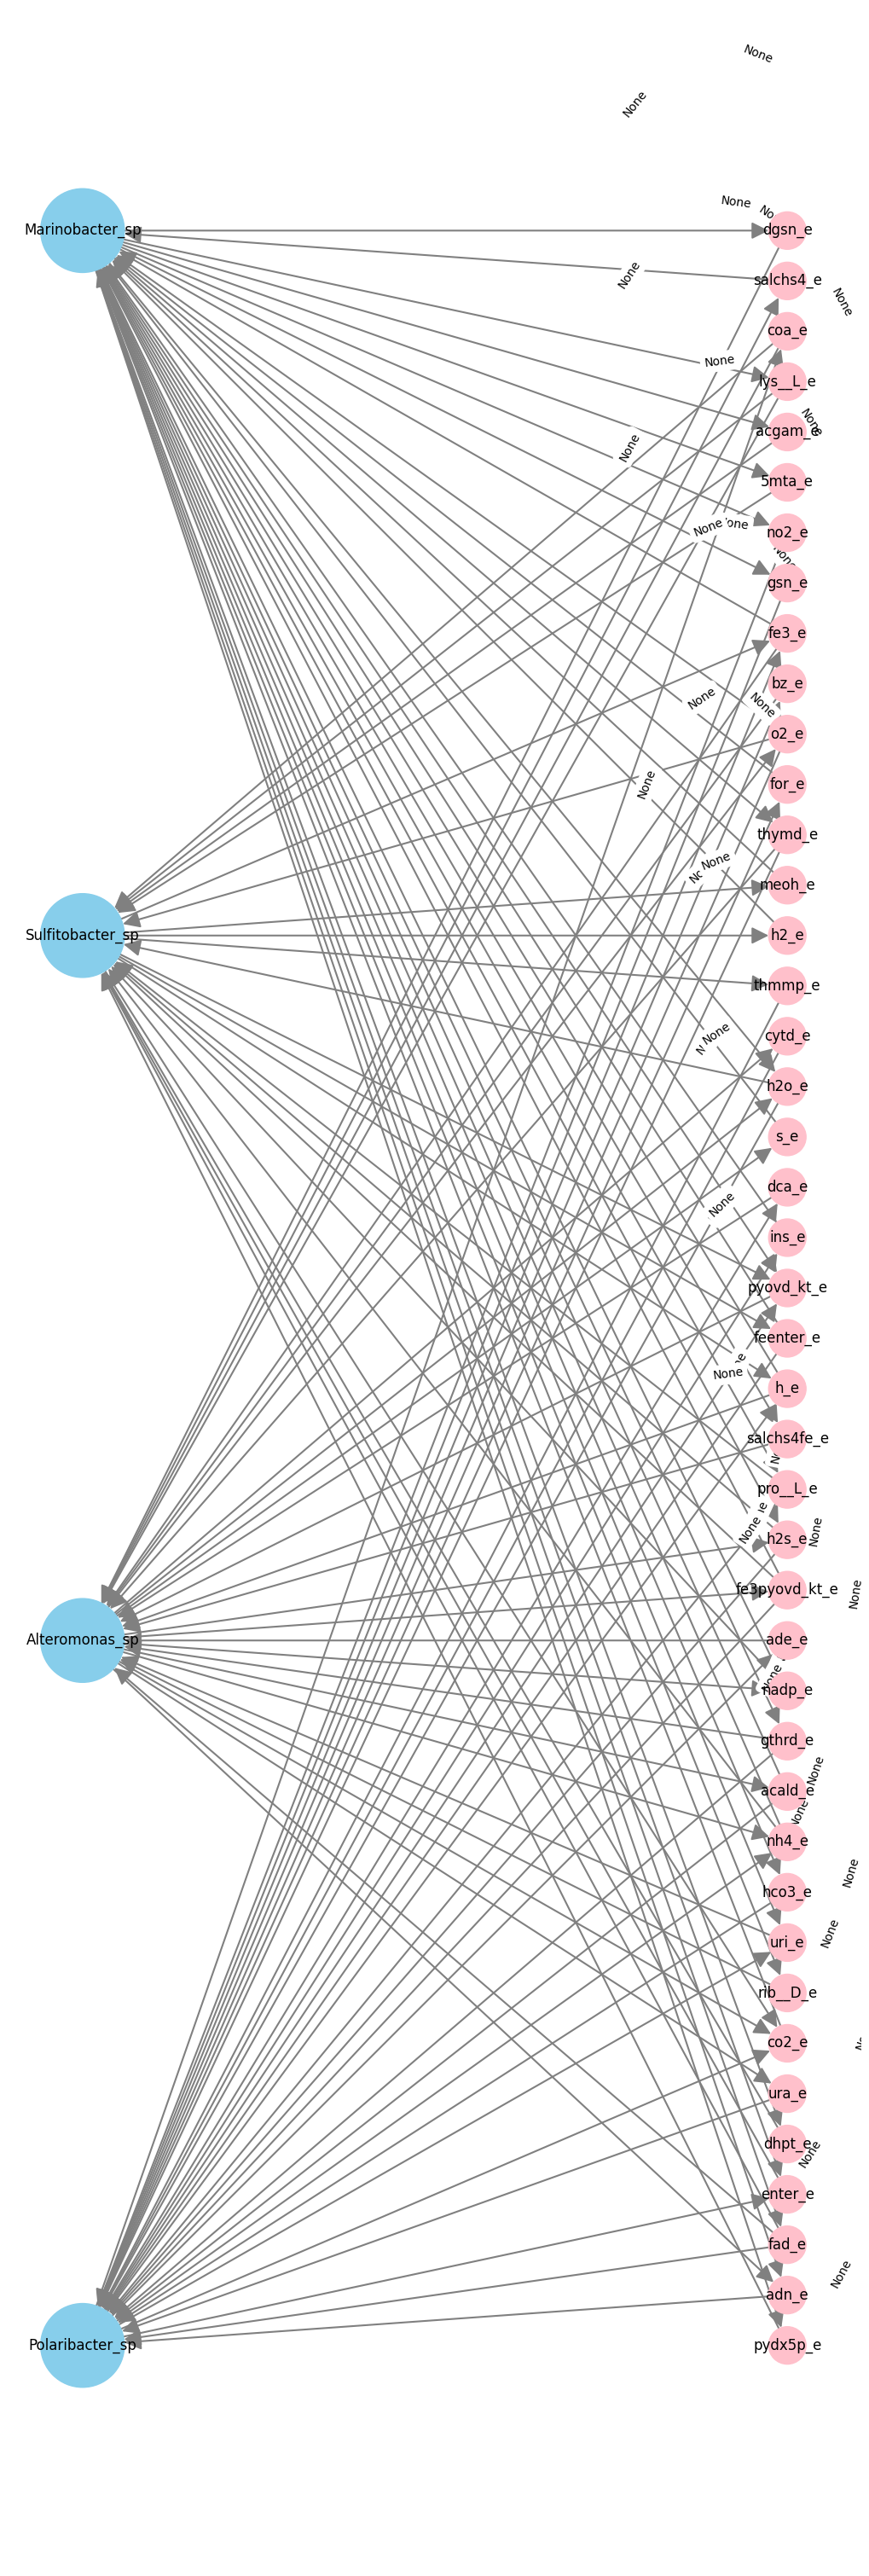

In [60]:
import networkx as nx
from matplotlib import pyplot as plt
from phycogem.visualization import get_graph_object_from_smetana_table


bipartite_graph = get_graph_object_from_smetana_table(
    final_df,
    output_graph="../results/micom/graph.json",
    weight=None,
    )

large_node_size = 5000
small_node_size = 1000
plt.figure(figsize=(10, 30))

nx.draw(
    bipartite_graph,
    nx.bipartite_layout(bipartite_graph, [n for n, d in bipartite_graph.nodes(data=True) if d['bipartite']==0]),
    with_labels=True,
    node_size=[
        large_node_size if bipartite == 0 else small_node_size
        for bipartite in nx.get_node_attributes(bipartite_graph, 'bipartite').values()
    ],
    node_color=[
        'skyblue' if bipartite == 0 else 'pink'
        for bipartite in nx.get_node_attributes(bipartite_graph, 'bipartite').values()
    ],
    edge_color='gray',
    arrowsize=30,
    width=1.5
)
nx.draw_networkx_edge_labels(
    bipartite_graph,
    nx.circular_layout(bipartite_graph),
    edge_labels=nx.get_edge_attributes(bipartite_graph, 'weight'),
)
plt.show()

In [43]:
from micom.viz import plot_exchanges_per_taxon

pl = plot_exchanges_per_taxon(res, filename="../results/micom/niche.html", perplexity=0.01)